In [1]:
import timeit

import numpy as np
import matplotlib.pyplot as plt

from scripts.queso_model import model_vars, model_data, objective_func, balance, alloc_df
# Ejecutar esta línea si pymoo no ha sido instalado
# %pip install -U pymoo

# Algoritmo Genético
Utilizando la librería [pymoo](https://pymoo.org/index.html), redefiniendo los operadores para cumplir con las restricciones del modelo de optimización.

## Parámetros

In [2]:
# ¿Cómo se obtienen estas variables desde el sistema de información?

# Carpeta con los datos
folder = './data/test2/'
# Datos de centros de acopio
info_acopios = 'centros_acopio.xlsx'
# Matriz de costos de transporte entre CA
costo_transporte = 'costo_transporte.xlsx'
# Matriz de tiempos de transporte entre CA
tiempo_transporte = 'tiempos_transporte.xlsx'
# Demanda del cliente
demanda = 3000
# Costo por unidad de tiempo
ctiempo = 100

# Probabilidad de cruce
p_cross = 0.8
# Probabilidad de mutación
p_mutate = 0.9
# Tamaño de la población
pop_size = 100
# Número de iteraciones antes de finalizar 
# al no encontrar una mejor solución
period = 100
# Máximo número de generaciones
max_gen = 1000
# Máximo de evaluaciones de función objetivo
max_evals = 100000

In [3]:
archivos = {
    'info_acopios': info_acopios,
    'costo_transporte' : costo_transporte,
    'tiempo_transporte' : tiempo_transporte,
}

data = model_data(archivos, demanda, ctiempo, folder=folder)

demanda = data['demanda']
ctiempo = data['ctiempo']
# t_max = data['t_max']
params_df = data['params_df']

N, seed, capacidades = model_vars(params_df)

## Definición 
Del modelo de optimización

In [4]:
from pymoo.core.problem import ElementwiseProblem

xl = np.zeros(capacidades.shape[0])
xu = capacidades


class Queso(ElementwiseProblem):
    def __init__(self):
        super().__init__(
            n_var=len(xl),
            n_obj=1,
            n_eq_constr=1,
            xl=xl,
            xu=xu
        )

    def _evaluate(self, x, out, *args, **kwargs):
        out['F'] = objective_func(x, N, data)
        # Se retira el último elemento del vector (centro de acopio principal), 
        # para validar la restricción de igualdad
        individual = np.delete(x, N * 2)
        out['H'] = demanda - np.sum(individual)


model = Queso()

## Generación 
De nuevas posibles soluciones

In [5]:
from pymoo.core.sampling import Sampling


class TopOrZeroSampling(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        gen_matrix = np.zeros((n_samples, problem.n_var), dtype=float)
        # Se indexan los centros de acopio
        n_vars = problem.n_var

        for i in range(n_samples):
            # Se reorganizan todos los índices de los centros de acopio, de forma aleatoria
            indices = np.arange(n_vars - 1)
            np.random.shuffle(indices)

            while np.sum(gen_matrix[i]) < demanda and indices.size > 0:
                idx = indices[0]
                gen_matrix[i, idx] += capacidades[idx]
                indices = np.delete(indices, 0)

                if np.sum(gen_matrix[i]) > demanda:
                    gen_matrix[i, idx] = gen_matrix[i, idx] - (np.sum(gen_matrix[i]) - demanda)
                    break

            gen_matrix[i, N * 2] = np.random.randint(capacidades[N * 2] + 1)

        return gen_matrix

## Cruce

Implementación de cruce en un punto

In [6]:
from pymoo.core.crossover import Crossover

class SinglePointCross(Crossover):
    def __init__(self, prob):
        # Para la implementación personalizada de este método, se consideraron 2 padres,
        # entonces cambiar los valores de la llamada a init no tendrá efecto.
        # Lo mismo pasa con el único offspring.
        super().__init__(n_parents=2, n_offsprings=1, prob=prob)

    def _do(self, problem, X, **kwargs):
        # n_parents, n_matings, n_var
        _, n_matings, n_var = X.shape

        T = np.zeros((1, n_matings, n_var))
        Y = np.full_like(T, None, dtype=float)

        for idx in range(n_matings):

            # Primera mitad
            p1 = X[0, idx, : n_var//2]
            # Segunda mitad
            p2 = X[1, idx, n_var//2 : n_var - 1]

            offspring = np.concatenate((p1, p2))

            if np.sum(offspring) > demanda:
                delta = np.sum(offspring) - demanda
                balance(offspring, capacidades, delta, True)
            else:
                delta = demanda - np.sum(offspring)
                balance(offspring, capacidades, delta, False)

            for i in range(offspring.shape[0]):
                Y[0, idx, i] = offspring[i]

            # Centro de acopio principal (última posición)
            main = np.random.choice([X[0, idx, n_var-1], X[1, idx, n_var-1]])
            Y[0, idx, n_var-1] = main

        return Y

## Mutación
Con una probabilidad dada, reasignar la cantidad asignada a un centro de acopio **o**, reasignar el centro de acopio principal.

In [7]:
from pymoo.core.mutation import Mutation

class ReassignMutation(Mutation):
    def __init__(self, prob):
        super().__init__()
        self.prob = prob

    def _do(self, problem, X, **kwargs):
        for i in range(len(X)):
            r = np.random.random()

            if r < self.prob:
                # Se toma un índice aleatorio
                individual = X[i]
                idx_mut = np.random.randint(individual.shape)

                # Si es el índice del centro de acopio principal (N*2)
                if idx_mut == N*2:
                    X[i, problem.n_var-1] = np.random.randint(capacidades[N * 2] + 1)

                else:
                    if individual[idx_mut] == 0:
                        # Se asigna la máxima cantidad posible del índice
                        delta = capacidades[idx_mut]
                        individual[idx_mut] = capacidades[idx_mut]
                        diff = True
                    else:
                        # Se asigna cero a la cantidad del índice
                        delta = individual[idx_mut]
                        individual[idx_mut] = 0
                        diff = False

                    balance(individual, capacidades, delta, diff)

                    for j in range(individual.shape[0]):
                        X[i, j] = individual[j]

        return X

## Aplicación

Definición del algoritmo genético


In [8]:
from pymoo.algorithms.soo.nonconvex.ga import GA

algorithm = GA(
    pop_size=pop_size,
    sampling=TopOrZeroSampling(),
    crossover=SinglePointCross(prob=p_cross),
    mutation=ReassignMutation(prob=p_mutate),
    eliminate_duplicates=True
)


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False



Criterio de terminación: https://pymoo.org/interface/termination.html

In [9]:
# Criterios simples
# from pymoo.termination import get_termination

# termination = get_termination('n_eval', 1000)
# termination = get_termination('n_gen', 50)
# termination = get_termination('time', '00:00:03')

from pymoo.termination.default import DefaultSingleObjectiveTermination

termination = DefaultSingleObjectiveTermination(
    # Definición de tolerancia para lo que se 
    # considera una solución diferente
    xtol=1e-8,
    cvtol=1e-6,
    ftol=1e-6,
    period=period, 
    n_max_gen=max_gen,
    n_max_evals=max_evals
)

Optimización y resultados

In [10]:
from pymoo.optimize import minimize

t_start_ga = timeit.default_timer()
ga = minimize(model, algorithm, termination, seed=seed, save_history=True, verbose=False)
t_end_ga = timeit.default_timer()

t_delta_ga = t_end_ga - t_start_ga

In [11]:
print(f'Centro de acopio principal: {params_df['Id_CA'].iloc[int(ga.X[N * 2])]}')
print(f'Precio: {ga.F}')
print(f'Tiempo: {round(t_delta_ga * 1000)}ms, ({t_delta_ga})')

Centro de acopio principal: CA1
Precio: [61800986.08130866]
Tiempo: 10345ms, (10.345453500000076)


In [12]:
asignaciones = alloc_df(ga.X, params_df, N, capacidades)
asignaciones.head()

,index,CAcopio,Capacidad,Asignada
0,0,CA1 Stock,1256.0,1244.0
1,1,CA1 Potencial,223.0,223.0
2,2,CA2 Stock,1830.0,0.0
3,3,CA2 Potencial,242.0,0.0
4,4,CA3 Stock,1350.0,0.0


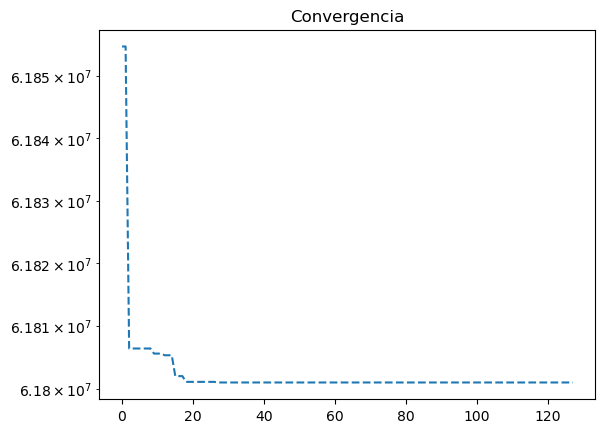

In [13]:
n_evals = np.array([e.evaluator.n_eval for e in ga.history])
opt = np.array([e.opt[0].F for e in ga.history])
gen_evals = np.arange(opt.shape[0])

plt.title('Convergencia')
plt.plot(gen_evals, opt, '--')
plt.yscale('log')
plt.show()

## Resultados

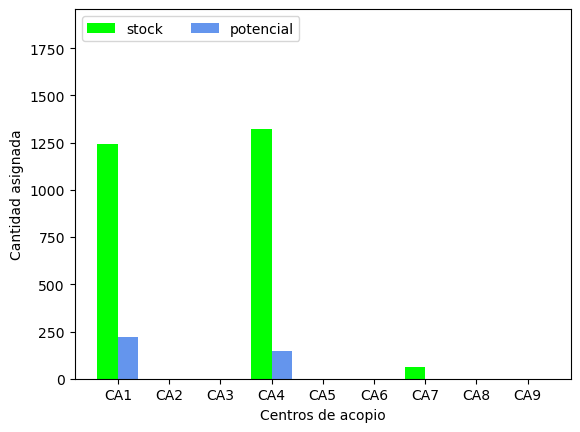

In [14]:
even = np.arange(0, N*2-1, 2)
odd = np.arange(1, N*2, 2)

cap_stock = np.take(capacidades, even)
cap_potencial = np.take(capacidades, odd)

ca_stock = np.take(ga.X, even)
ca_potencial = np.take(ga.X, odd)

labels = params_df['Id_CA']
x = np.arange(len(labels))
y1 = ca_stock
y2 = ca_potencial

fig, ax = plt.subplots()
y_lim = np.array(np.mean([np.max(capacidades), np.max(ga.X)])) * 1.1
ax.set_ylim([0, y_lim])
x1_bar = ax.bar(x-0.2, y1, width=0.4, label='stock', color='lime')
x2_bar = ax.bar(x+0.2, y2, width=0.4, label='potencial', color='cornflowerblue')

plt.xticks(x, labels)
plt.xlabel('Centros de acopio')
plt.ylabel('Cantidad asignada')
plt.legend(loc='upper left', ncol=2)
plt.show()

testing https://pymoo.org/visualization/heatmap.html

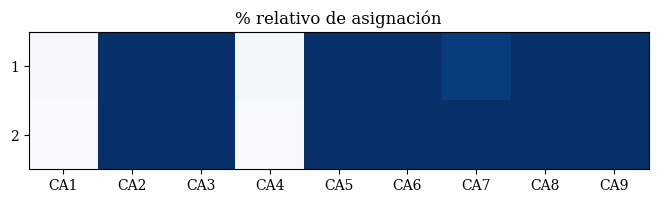

In [15]:
from pymoo.visualization.heatmap import Heatmap

ca_stock_norm = ca_stock / cap_stock
ca_potencial_norm = ca_potencial / cap_potencial
ca_heatmap = np.vstack((ca_stock_norm, ca_potencial_norm))

heatmap = Heatmap(bounds=(0, 1),
                  title='% relativo de asignación',
                  cmap='Blues',
                  labels=labels.values.tolist(),
                  y_labels=['Stock', 'Potencial'])
heatmap.add(ca_heatmap)
heatmap.show()

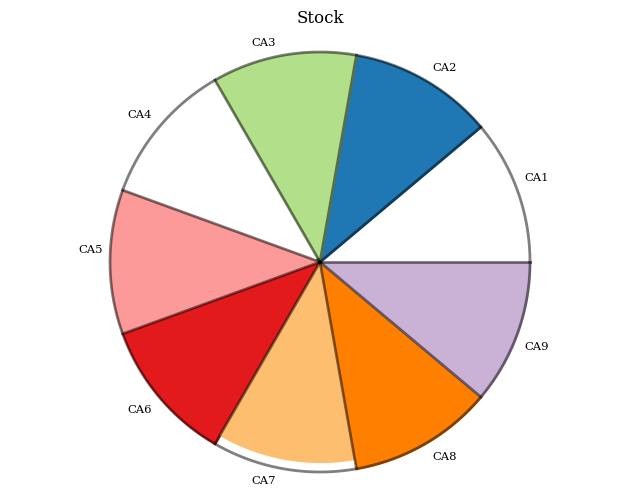

In [16]:
from pymoo.visualization.petal import Petal

petal = Petal(bounds=(0, 1),
              cmap='Paired',
              title='Stock',
              labels=labels.values.tolist(),
              reverse=True)
petal.add(ca_stock_norm)
petal.show()

In [17]:
petal = Petal(bounds=(0, 1),
              cmap='Set3_r',
              title='Potencial',
              labels=labels.values.tolist(),
              reverse=True)
petal.add(ca_potencial_norm)
# petal.show()